In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.rcParams.update({'font.size': 24}) #make plots more readable
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

import palettable as pal

import MagellanicStream as ms

from scipy.stats import binned_statistic_2d, binned_statistic

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    '''
    - data: some 1d array-like object that possibly has duplicate values
    Returns dictionary of duplicates and array of indices
    '''
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

def dist2LMC(ra, dec, alph0, delt0, pa, io):
    '''
    - ra: right ascension of stars
    - dec: declination of stars
    - alph0: right ascension of center of LMC
    - delt0: declination of center of LMC
    - pa: position angle of line of nodes
    - io: inclination of LMC disk
    Calculate distance to stars in LMC assuming an inclined disk in the sky
    '''
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat):
    '''
    Calculate the median absolute deviation of 1d array-like object dat
    '''
    return np.median(np.absolute(dat - np.median(dat)))

######################################
### Get Cartesian Coordinates (MC) ### 
######################################

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis
        
def kthbitset(arr, k):
    boo = []
    for i in range(len(arr)):
        if arr[i] & (1 << (k-1)):
            boo.append('True')
        else:
            boo.append('False')
    return np.asarray(boo)

In [3]:
#APOGEE MW (starhorse VAC)
horse = fits.getdata('/Users/joshpovick/desktop/research/LMC_Gradients/apogee_starhorse-DR16.fits.gz',1)
# clnr = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
#                 (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))


apodr16 = fits.getdata('/Users/joshpovick/desktop/research/LMC_Gradients/allStar-r12-l33.fits.gz',1) 
cln = np.where(apodr16['GAIA_R_EST']!=-9999.0) 

comb, horse_ind, apodr16_ind = np.intersect1d(horse['APOGEE_ID'], 
                                              apodr16['APOGEE_ID'][cln],return_indices=True)
matdr16 = apodr16[cln][apodr16_ind]

In [5]:
# len(donortable1)

In [6]:
help(ascii.read)

Help on function read in module astropy.io.ascii.ui:

read(table, guess=None, **kwargs)
    Read the input ``table`` and return the table.  Most of
    the default behavior for various parameters is determined by the Reader
    class.
    
    See also:
    
    - http://docs.astropy.org/en/stable/io/ascii/
    - http://docs.astropy.org/en/stable/io/ascii/read.html
    
    Parameters
    ----------
    table : str, file-like, list, `pathlib.Path` object
        Input table as a file name, file-like object, list of strings,
        single newline-separated string or `pathlib.Path` object .
    guess : bool
        Try to guess the table format. Defaults to None.
    format : str, `~astropy.io.ascii.BaseReader`
        Input table format
    Inputter : `~astropy.io.ascii.BaseInputter`
        Inputter class
    Outputter : `~astropy.io.ascii.BaseOutputter`
        Outputter class
    delimiter : str
        Column delimiter string
    comment : str
        Regular expression defining a 

In [4]:
donortable1 = pd.read_csv('table1.dat', delimiter='\s+',skiprows=27)
donortable2 = pd.read_csv('table2.dat',delimiter='\s+',skiprows=42)

donortable1 = Table.from_pandas(donortable1)
donortable2 = Table.from_pandas(donortable2)

donortable2.fill_value = -9999.0
donortable2 = donortable2.filled()

In [5]:
### Calculate the Galactic Circular Radius for MW ###
import astropy.units as u
import astropy.coordinates as coord

pos = coord.ICRS(ra=matdr16['RA']*u.degree,dec=matdr16['DEC']*u.degree,
                 distance=(horse['dist50'][horse_ind])*u.kpc)
galmwpos = pos.transform_to(coord.Galactocentric)

galmwrad = []
for i in range(len(pos)):
    xpo = (galmwpos[i].x).value
    ypo = (galmwpos[i].y).value
    galmwrad.append(np.sqrt(xpo**2+ypo**2))
    
galmwrad = np.asarray(galmwrad)

### Select stars with radius 4 to 12 kpc and less than 1 kpc in z ###
selstars = np.where((galmwrad>=4.0)&(galmwrad<=15.0)&((galmwpos.z).value<=1.0))

In [6]:
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

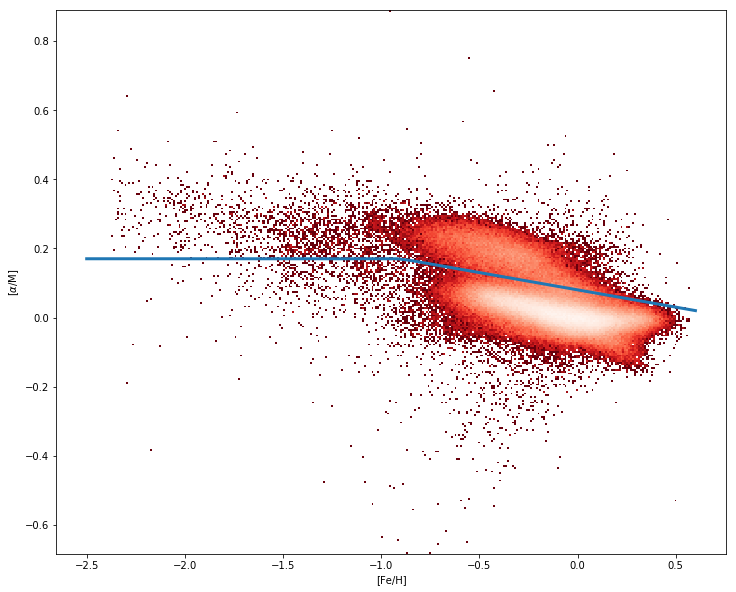

In [7]:
plt.figure(figsize=[12,10])
xval = np.linspace(-2.5,0.6)
def alptrendline(x):
    #return -0.16119885604431136*x+0.028160372474993145
    x = np.asarray(x)
    y = np.zeros(x.shape)
    y += (x<=-0.9)*(-0.1*(-0.9)+0.08)
    y += (x>-0.9)*(-0.1*x+0.08)
    return y
 
clnalp = np.where((matdr16[selstars]['ALPHA_M']>=-100)&(matdr16[selstars]['FE_H']>=-100))
density = binned_statistic_2d(matdr16[selstars][clnalp]['FE_H'],matdr16[selstars][clnalp]['ALPHA_M'],
                              None,'count',bins=300)
plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
                                                                 density.y_edge[0],density.y_edge[-1]],
           aspect='auto', interpolation='nearest',cmap='Reds_r',label='_nolegend_')
plt.plot(xval,alptrendline(xval),lw=3.0)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/M]')
plt.savefig('alphaplot.pdf',bbox_inches='tight')
plt.show()

In [8]:
clnalp = np.where((matdr16[selstars]['ALPHA_M']>=-100)&(matdr16[selstars]['FE_H']>=-100))
# A = np.vstack([matdr16[selstars][clnalp]['FE_H'],np.ones(len(matdr16[selstars][clnalp]['FE_H']))]).T
# m, b = np.linalg.lstsq(A, matdr16[selstars][clnalp]['ALPHA_M'])[0]
# print(m)
# print(b)

alphstars = matdr16[selstars][clnalp]

In [9]:
thin_thick = []
for i in range(len(alphstars['ALPHA_M'])):
    if alphstars['FE_H'][i] <= -0.9:
        if alphstars['ALPHA_M'][i] < (-0.1*(-0.9)+0.08):
            thin_thick.append(0.0)
        else:
            thin_thick.append(1.0)
    elif alphstars['FE_H'][i] > -0.9:
        if (-0.1*(alphstars['FE_H'][i])+0.08 > alphstars['ALPHA_M'][i]):
            thin_thick.append(0.0)
        else:
            thin_thick.append(1.0)

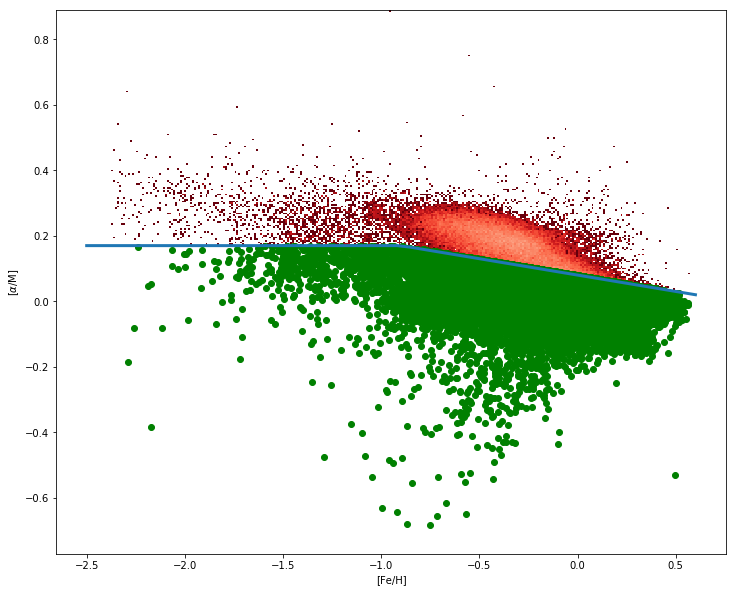

In [10]:
thin = np.where(np.asarray(thin_thick)==0.0)

plt.figure(figsize=[12,10])
xval = np.linspace(-2.5,0.6)
def alptrendline(x):
    #return -0.16119885604431136*x+0.028160372474993145
    x = np.asarray(x)
    y = np.zeros(x.shape)
    y += (x<=-0.9)*(-0.1*(-0.9)+0.08)
    y += (x>-0.9)*(-0.1*x+0.08)
    return y
 
# clnalp = np.where((matdr16[selstars]['ALPHA_M']>=-100)&(matdr16[selstars]['FE_H']>=-100))
density = binned_statistic_2d(alphstars['FE_H'],alphstars['ALPHA_M'],
                              None,'count',bins=300)
plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
                                                                 density.y_edge[0],density.y_edge[-1]],
           aspect='auto', interpolation='nearest',cmap='Reds_r',label='_nolegend_')
plt.plot(xval,alptrendline(xval),lw=3.0)
plt.scatter(alphstars[thin]['FE_H'],alphstars[thin]['ALPHA_M'],c='green')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/M]')
# plt.savefig('alphaplot.pdf',bbox_inches='tight')
plt.show()

In [11]:
labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

In [12]:
from scipy.stats import binned_statistic_2d
import statsmodels.api as sm 

# matplotlib.rcParams.update({'font.size': 18})

# mw_grads = []
# for i in range(len(elems)-5):
#     xval = np.linspace(4.0,12.0)
    
#     #Calculate the Gradient
#     cln = np.where((alphstars[thin][elems[i]]>-100)&(alphstars[thin]['SNR']>=100))
#     pmodl = np.array(galmwrad[selstars][thin][cln]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.RLM(alphstars[thin][elems[i]][cln],pmodl).fit()
    
#     mw_grads.append(model.params[1])
    
#     def trendline(x):
#         return model.params[1]*x+model.params[0]
    
#     plt.figure(figsize=[12,10])
    
#     density = binned_statistic_2d(galmwrad[selstars][thin][cln],alphstars[thin][elems[i]][cln],None,'count',bins=300)
#     plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
#                                                                      density.y_edge[0],density.y_edge[-1]],
#                aspect='auto', interpolation='nearest',cmap='Reds_r',label='_nolegend_')

#     plt.plot(xval,trendline(xval),c='r',lw=3.0,label='Trend: {:>5.3f}$ \,dex/kpc$'.format(model.params[1]))
#     plt.legend(loc='lower right')
#     plt.title(r'{} Radial MW Abundance Trend, Color as Log(count)'.format(labs[i]))
#     plt.ylabel(r'{}'.format(labs[i]))
#     plt.xlabel(r'MW Galactic Circular Radius (kpc)')
#     plt.savefig('MWrad{}.pdf'.format(els[i]),bbox_inches='tight')
#     plt.show()

In [16]:
# from scipy.stats import binned_statistic_2d
# import statsmodels.api as sm 

# matplotlib.rcParams.update({'font.size': 18})

# #### DON'T USE M/H or Fe/H FROM THIS

# labsH = ['[M/H]','[C/H]','[N/H]','[O/H]','[Na/H]','[Mg/H]','[Al/H]','[Si/H]','[P/H]','[S/H]','[K/H]',
#         '[Ca/H]','[Ti/H]','[TiII/H]','[V/H]','[Cr/H]','[Mn/H]','[Fe/H]','[Co/H]','[Ni/H]','[Cu/H]',
#         '[Ge/H]','[Rb/H]','[Ce/H]','[Nd/H]','[Yb/H]']

# mw_grads = []
# for i in range(len(elems)-5):
#     xval = np.linspace(4.0,12.0)
    
#     #Calculate the Gradient
#     cln = np.where((alphstars[thin][elems[i]]>-100)&(alphstars[thin]['SNR']>=100))
#     pmodl = np.array(galmwrad[selstars][thin][cln]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(alphstars[thin][elems[i]][cln]+alphstars[thin]['FE_H'][cln],pmodl).fit()
    
#     mw_grads.append(model.params[1])
    
#     def trendline(x):
#         return model.params[1]*x+model.params[0]
    
#     plt.figure(figsize=[12,10])
    
#     density = binned_statistic_2d(galmwrad[selstars][thin][cln],alphstars[thin][elems[i]][cln]+
#                                   alphstars[thin]['FE_H'][cln],None,'count',bins=300)
#     plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
#                                                                      density.y_edge[0],density.y_edge[-1]],
#                aspect='auto', interpolation='nearest',cmap='Reds_r',label='_nolegend_')

#     plt.plot(xval,trendline(xval),c='r',lw=3.0,label='Trend: {:>5.3f}$ \,dex/kpc$'.format(model.params[1]))
#     plt.legend(loc='lower right')
#     plt.title(r'{} Radial MW Abundance Trend, Color as Log(count)'.format(labsH[i]))
#     plt.ylabel(r'{}'.format(labsH[i]))
#     plt.xlabel(r'MW Galactic Circular Radius (kpc)')
#     plt.savefig('MWradH1{}.pdf'.format(els[i]),bbox_inches='tight')
#     plt.show()

In [13]:
allmw_Fe_grads = []
lowmw_Fe_grads = []
for i in tqdm_notebook(range(len(elems)-5),desc='all'):
    cln = np.where((alphstars[elems[i]]>-100)&(alphstars['SNR']>=100))
    pmodl = np.array(galmwrad[selstars][cln]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(alphstars[elems[i]][cln],pmodl).fit()
    allmw_Fe_grads.append(model.params[1])
    
for i in tqdm_notebook(range(len(elems)-5),desc='low'):
    cln = np.where((alphstars[thin][elems[i]]>-100)&(alphstars[thin]['SNR']>=100))
    pmodl = np.array(galmwrad[selstars][thin][cln]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(alphstars[thin][elems[i]][cln],pmodl).fit()
    lowmw_Fe_grads.append(model.params[1])
    
thick = np.delete(range(len(alphstars)),thin)
higmw_Fe_grads = []
for i in tqdm_notebook(range(len(elems)-5),desc='high'):
    cln = np.where((alphstars[thick][elems[i]]>-100)&(alphstars[thick]['SNR']>=100))
    pmodl = np.array(galmwrad[selstars][thick][cln]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(alphstars[thick][elems[i]][cln],pmodl).fit()
    higmw_Fe_grads.append(model.params[1])

In [18]:
# def noisy(abund,abund_err):
    
#     '''
#     - abund: abundnace to add noise to
#     - abund_err: error in abund
#     '''

#     abundnoise = np.random.normal(0,scale=abund_err)
#     abundnew = abund + abundnoise

#     return abundnew

In [14]:
scale = 1.0 #MW radial scale height

mwnoisy_values = []
mwm_devs = []
mwb_devs = []
for j in tqdm_notebook(range(len(elems)-5),desc='elements'):
    mwslopes = []
    mwinters = []
    
    cln = np.where((alphstars[thin][elems[j]]>-100)&(alphstars[thin]['SNR']>=100))
    clnstrs = alphstars[thin][elems[j]][cln]
    
    for k in tqdm_notebook(range(500),desc='iterations'):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        pmodl = np.array(galmwrad[selstars][thin][cln][ind]/scale).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(indstrs,pmodl).fit()
        mwslopes.append(model.params[1])
        mwinters.append(model.params[0])
        
    mwm_devs.append(mad(mwslopes))
    mwb_devs.append(mad(mwinters))

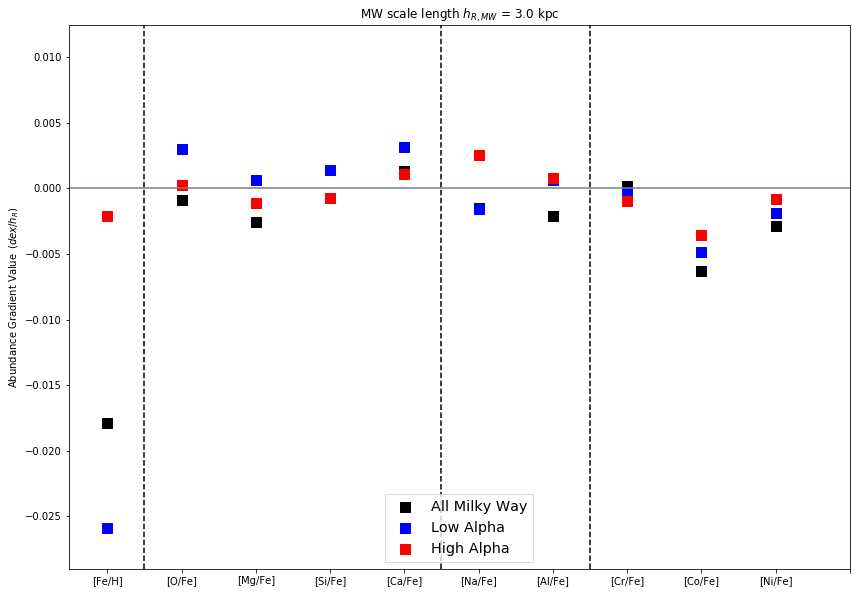

In [15]:
good_idx = [17,3,5,7,11,4,6,15,18,19] #[16,4,6,10,3,5,14,2,17,18]  # #[2,3,4,5,6,10,14,16,17,18]

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
         np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
         np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
         np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
         np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

all_mw = []
low_mw = []
hig_mw = []


for i in idx:

    all_mw.append(allmw_Fe_grads[i])
    low_mw.append(lowmw_Fe_grads[i])
    hig_mw.append(higmw_Fe_grads[i])
    

fig = plt.figure(figsize=[14,10])

# plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_over,marker='*',c='black',label='LMC Overall',s=200)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_over,yerr=scerr_over,c='black',capsize=5.0,ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],all_mw,marker='s',c='k',label='All Milky Way',s=100)
plt.scatter([0,1,2,3,4,5,6,7,8,9],low_mw,marker='s',c='b',label='Low Alpha',s=100)
plt.scatter([0,1,2,3,4,5,6,7,8,9],hig_mw,marker='s',c='r',label='High Alpha',s=100)

# plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_mw,scerr_mw,c='violet',capsize=5.0,ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/h_{R})$')

# plt.gca().set_ylim(top=0.05)

# plt.text(-0.375,0.07,'Iron',fontsize=30)
# plt.text(2.25,0.07,'$\\alpha$',fontsize=30)
# plt.text(4.9,0.07,'Odd Z',fontsize=30)
# plt.text(7.25,0.07,'Iron Peak',fontsize=30)

plt.title(r'MW scale length $h_{R,MW}$ = 3.0 kpc')

plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='x-large')
# plt.savefig('mwanLMConly.pdf',bbox_inches='tight')
plt.show()

In [22]:
# mwnoisy_values = []
# mwm_devs = []
# mwb_devs = []
# for j in tqdm_notebook(range(len(elems)-5),decs='elements'):
#     mwslopes = []
#     mwinters = []
    
#     cln = np.where((alphstars[thin][elems[j]]>-100)&(alphstars[thin]['SNR']>=100))
#     clnstrs = alphstars[thin][elems[j]][cln]
    
#     for k in tqdm_notebook(range(1000),desc='iterations'):
        
#         #print(str(j)+', '+str(k))
        
#         ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
#         indstrs = clnstrs[ind]
        
#         pmodl = np.array(galmwrad[selstars][thin][cln][ind]).T
#         pmodl = sm.add_constant(pmodl)
#         model = sm.RLM(indstrs,pmodl).fit()
#         mwslopes.append(model.params[1])
#         mwinters.append(model.params[0])
        
#     mwm_devs.append(mad(mwslopes))

(0, 100)

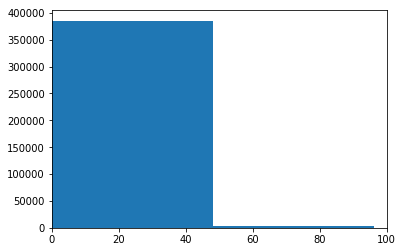

In [23]:
plt.hist(horse['dist95'])
plt.xlim(0,100)

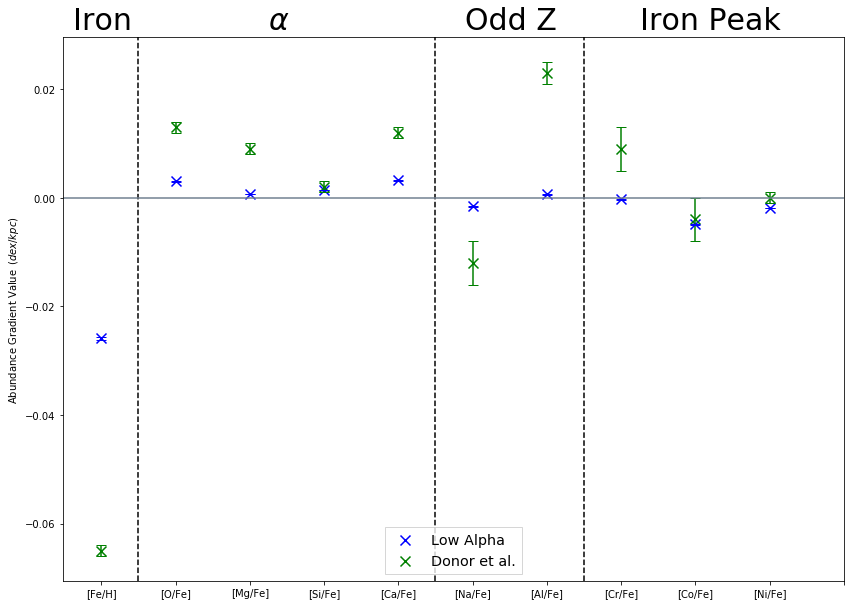

In [24]:
idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
         np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
         np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
         np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
         np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

all_mw = []
low_mw = []
hig_mw = []
scerr_mw = []

#Fe, O, Mg, Si, Ca, Na, Al, Cr, Co, Ni
donor_grads = [-0.065,0.013,0.009,0.002,0.012,-0.012,0.023,0.009,-0.004,0.000]
donor_devs = [0.001,0.001,0.001,0.001,0.001,0.004,0.002,0.004,0.004,0.001]

for i in idx:

    all_mw.append(allmw_Fe_grads[i])
    low_mw.append(lowmw_Fe_grads[i])
    hig_mw.append(higmw_Fe_grads[i])
    scerr_mw.append(mwm_devs[i])
    

fig = plt.figure(figsize=[14,10])

# plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_over,marker='*',c='black',label='LMC Overall',s=200)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_over,yerr=scerr_over,c='black',capsize=5.0,ls='none')

# plt.scatter([0,1,2,3,4,5,6,7,8,9],all_mw,marker='s',c='k',label='All Milky Way',s=100)
plt.scatter([0,1,2,3,4,5,6,7,8,9],low_mw,marker='x',c='b',label='Low Alpha',s=100)
# plt.scatter([0,1,2,3,4,5,6,7,8,9],hig_mw,marker='s',c='r',label='High Alpha',s=100)
plt.scatter([0,1,2,3,4,5,6,7,8,9],donor_grads,marker='x',c='g',label='Donor et al.',s=100)

plt.errorbar([0,1,2,3,4,5,6,7,8,9],low_mw,scerr_mw,c='b',capsize=5.0,ls='none')
plt.errorbar([0,1,2,3,4,5,6,7,8,9],donor_grads,donor_devs,c='g',capsize=5.0,ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$')

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.031,'Iron',fontsize=30)
plt.text(2.25,0.031,'$\\alpha$',fontsize=30)
plt.text(4.9,0.031,'Odd Z',fontsize=30)
plt.text(7.25,0.031,'Iron Peak',fontsize=30)

# plt.title(r'MW Gradients')

plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='x-large')
# plt.savefig('mwanLMConly.pdf',bbox_inches='tight')
plt.show()

In [27]:
from scipy.stats import binned_statistic_2d
import statsmodels.api as sm 

matplotlib.rcParams.update({'font.size': 18})
donorelems = ['FEH','OFE','MGFE','SIFE','CAFE','NAFE','ALFE','CRFE','COFE','NIFE']

mw_grads = []
mw_intes = []
els2 = []

# yplotlab = ['[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Ca/Fe]','[Cr/Fe]','[Co/Fe]','[Fe/H]',
#             '[Ni/Fe]']

els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

labls = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
         '[Ca/Fe]','[Ti_Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
         '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']


donor_cls = [donortable1['FEH'],donortable2['OFE'],donortable2['MGFE'],donortable2['SIFE'],donortable2['CAFE'],
               donortable2['NAFE'],donortable2['ALFE'],donortable2['CRFE'],donortable2['COFE'],
               donortable2['NIFE']]

for j in tqdm_notebook(idx,desc='elements'):
    #Calculate the Gradient
    cln = np.where((alphstars[thin][elems[j]]>-100)&(alphstars[thin]['SNR']>=100))
    pmodl = np.array(galmwrad[selstars][thin][cln]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(alphstars[thin][elems[j]][cln],pmodl).fit()
    
    mw_grads.append(model.params[1])
    mw_intes.append(model.params[0])
    els2.append(els[j])

less_grads = []
less_intes = []
for k in tqdm_notebook(range(len(donorelems)),desc='less donor'):
    donorelems = ['FEH','OFE','MGFE','SIFE','CAFE','NAFE','ALFE','CRFE','COFE','NIFE']
    cln = np.where((donortable1['rgc']<15.0)&(donortable1['rgc']>4.0)&
                   (donortable2[donorelems[k]]!=-9999.0)&(donortable2[donorelems[k]]<100.0))
    pmodl = np.array(donortable1['rgc'][cln]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(donortable2[donorelems[k]][cln],pmodl).fit()
    
    less_grads.append(model.params[1])
    less_intes.append(model.params[0])

john_grads = []
john_intes = []
for k in tqdm_notebook(range(len(donorelems)),desc='less donor'):
    donorelems = ['FEH','OFE','MGFE','SIFE','CAFE','NAFE','ALFE','CRFE','COFE','NIFE']
    cln = np.where((donortable2[donorelems[k]]!=-9999.0)&(donortable2[donorelems[k]]<100.0))
    pmodl = np.array(donortable1['rgc'][cln]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(donortable2[donorelems[k]][cln],pmodl).fit()
    
    john_grads.append(model.params[1])
    john_intes.append(model.params[0])    

In [ ]:
# for i in tqdm_notebook(range(len(idx)),desc='plots'):
#     xval = np.linspace(4.0,12.0)
 
#     def trendline(x):
#         return mw_grads[i]*x+mw_intes[i]
    
#     def lessgrad(x):
#         return less_grads[i]*x+less_intes[i]
    
#     def johngrad(x):
#         return john_grads[i]*x+john_intes[i]
    
#     plt.figure(figsize=[12,10])
    
#     cln = np.where((alphstars[thin][elems[idx[i]]]>-100)&(alphstars[thin]['SNR']>=100))
#     density = binned_statistic_2d(galmwrad[selstars][thin][cln],alphstars[thin][elems[idx[i]]][cln],None,'count',
#                                   bins=300)
#     plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
#                                                                      density.y_edge[0],density.y_edge[-1]],
#                aspect='auto', interpolation='nearest',cmap='binary_r',label='_nolegend_')

#     bin_stats, bin_edges, binnumber = binned_statistic(galmwrad[selstars][thin][cln],
#                                                        alphstars[thin][elems[idx[i]]][cln],statistic='median',
#                                                        bins=[4,5,6,7,8,9,10,11,12])
#     plt.hlines(bin_stats, bin_edges[:-1], bin_edges[1:], colors='g', lw=5.0,label='Binned')
    
#     x_mids = np.array([4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
#     z = np.polyfit(x_mids, bin_stats, 1)
#     p = np.poly1d(z)
#     plt.plot(xval,p(xval),c='cyan',label='Binned Trend')
    
#     plt.plot(xval,trendline(xval),c='r',lw=3.0,label='Trend: {:>5.3f}$ \,dex/kpc$'.format(mw_grads[i]))
#     plt.plot(xval,lessgrad(xval),c='k',lw=3.0,label='FitJohnRegion: {:>5.3f}$ \,dex/kpc$'.format(less_grads[i]))
#     plt.plot(xval,johngrad(xval),c='yellow',lw=3.0,label='FitJohnAll: {:>5.3f}$ \,dex/kpc$'.format(john_grads[i]))
    
#     clnjohn = np.where((donortable2[donorelems[i]]!=-9999.0)&(donortable2[donorelems[i]]<100.0))
#     plt.scatter(donortable1['rgc'][clnjohn],donor_cls[i][clnjohn],c='magenta',marker='*',s=250,
#                 label='Donor: {:>5.3f}$ \,dex/kpc$'.format(donor_grads[i]))
#     plt.legend(loc='lower right')
#     plt.title(r'{} Radial MW Abundance Trend, Color as Log(count)'.format(labls[idx[i]]))
#     plt.ylabel(r'{}'.format(labls[idx[i]]))
#     plt.xlabel(r'MW Galactic Circular Radius (kpc)')
#     plt.xlim(4,12)
#     plt.ylim(top=1.5)
# #     plt.savefig('MWrad{}_w_donor.pdf'.format(els2[i]),bbox_inches='tight')
#     plt.show()

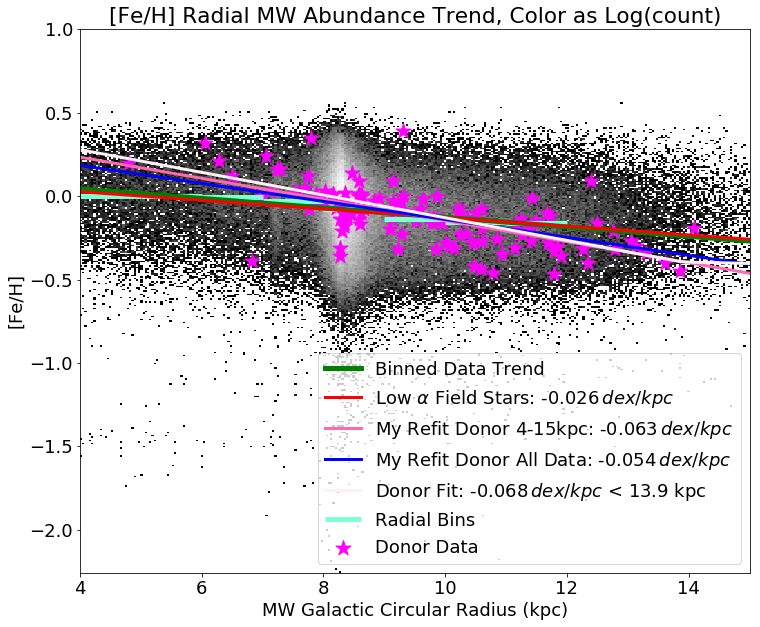

In [28]:
i = 0
xval = np.linspace(4.0,15.0)

fegrad = []
fegradsig = []
def trendline(x):
    return mw_grads[i]*x+mw_intes[i]
    
def lessgrad(x):
    return less_grads[i]*x+less_intes[i]
    
def johngrad(x):
    return john_grads[i]*x+john_intes[i]

def donorFetrend(x):
    x = np.asarray(x)
    y = np.zeros(x.shape)
    m1 = -0.068
    b1 = 0.550
    m2 = -0.008
    k = 13.9
    y += (x <= k)*(m1*x + b1)
    y += (x > k)*((m2*(x - k))+(m1*(k) + b1))
    return y
    
plt.figure(figsize=[12,10])
    
cln = np.where((alphstars[thin][elems[idx[i]]]>-100)&(alphstars[thin]['SNR']>=100))
density = binned_statistic_2d(galmwrad[selstars][thin][cln],alphstars[thin][elems[idx[i]]][cln],None,'count',
                                  bins=300)
plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
                                                                     density.y_edge[0],density.y_edge[-1]],
               aspect='auto', interpolation='nearest',cmap='binary_r',label='_nolegend_')

bin_stats, bin_edges, binnumber = binned_statistic(galmwrad[selstars][thin][cln],
                                                       alphstars[thin][elems[idx[i]]][cln],statistic='median',
                                                       bins=[4,5,6,7,8,9,10,11,12])
plt.hlines(bin_stats, bin_edges[:-1], bin_edges[1:], colors='aquamarine', lw=5.0,label='Radial Bins')
    
x_mids = np.array([4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
z,zcov = np.polyfit(x_mids, bin_stats, 1,cov=True)
fegrad.append(z[0])
fegradsig.append(np.sqrt(zcov[1,1]))
p = np.poly1d(z)
plt.plot(xval,p(xval),c='green',label='Binned Data Trend',lw=5.0)
    
plt.plot(xval,trendline(xval),c='r',lw=3.0,label=r'Low $\alpha$ Field Stars: {:>5.3f}$ \,dex/kpc$'.format(mw_grads[i]))
plt.plot(xval,lessgrad(xval),c='hotpink',lw=3.0,label='My Refit Donor 4-15kpc: {:>5.3f}$ \,dex/kpc$'.format(less_grads[i]))
plt.plot(xval,johngrad(xval),c='blue',lw=3.0,label='My Refit Donor All Data: {:>5.3f}$ \,dex/kpc$'.format(john_grads[i]))

plt.plot(xval,donorFetrend(xval),lw=3.0,c='lavenderblush',label='Donor Fit: {:>5.3}$ \,dex/kpc$ < 13.9 kpc'.format(-0.068,))

clnjohn = np.where((donortable2[donorelems[i]]!=-9999.0)&(donortable2[donorelems[i]]<100.0))
plt.scatter(donortable1['rgc'][clnjohn],donor_cls[i][clnjohn],c='magenta',marker='*',s=250,
                label='Donor Data')
plt.legend(loc='lower right')
plt.title(r'{} Radial MW Abundance Trend, Color as Log(count)'.format(labls[idx[i]]))
plt.ylabel(r'{}'.format(labls[idx[i]]))
plt.xlabel(r'MW Galactic Circular Radius (kpc)')
plt.xlim(4,15)
plt.ylim(top=1.0)
plt.savefig('MWrad{}_w_trends.pdf'.format(els2[i]),bbox_inches='tight')
plt.show()

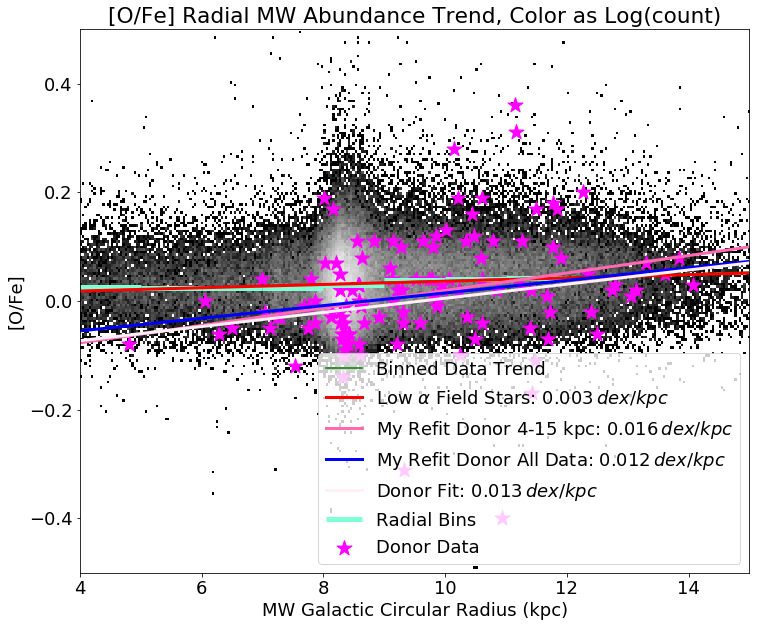

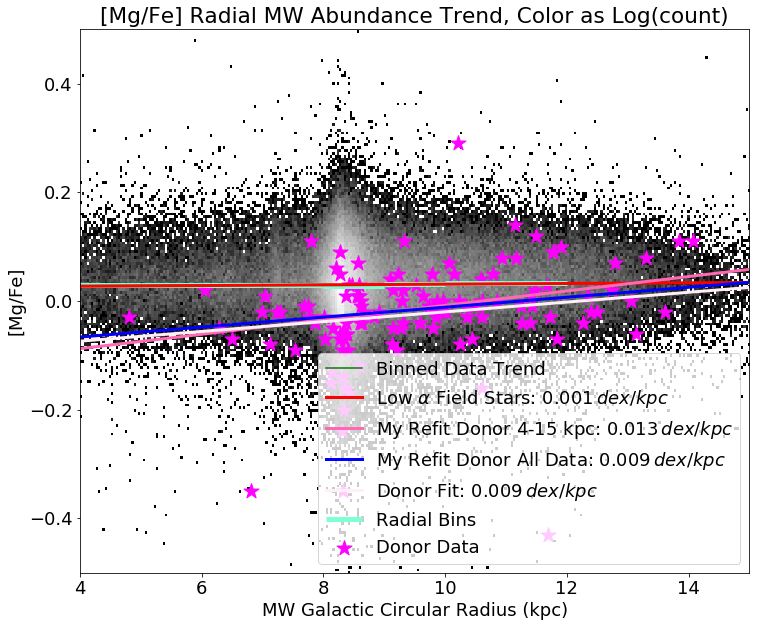

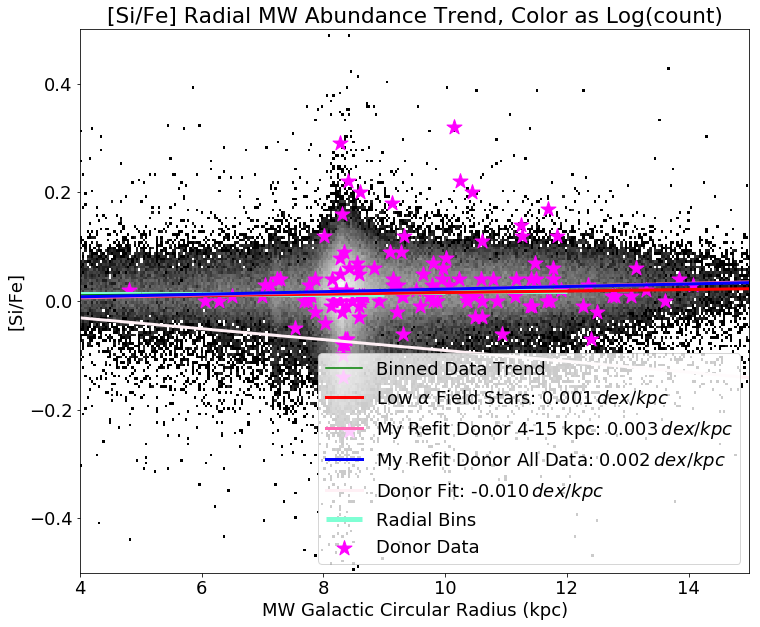

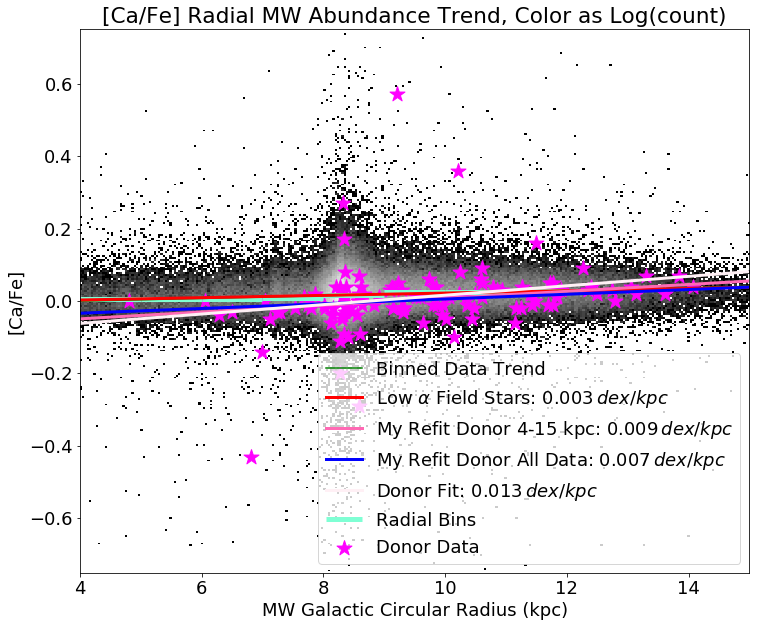

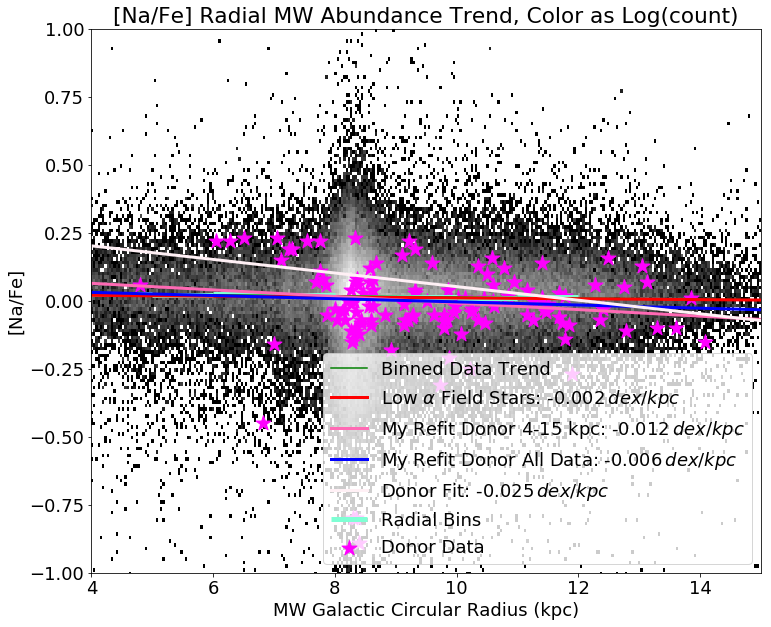

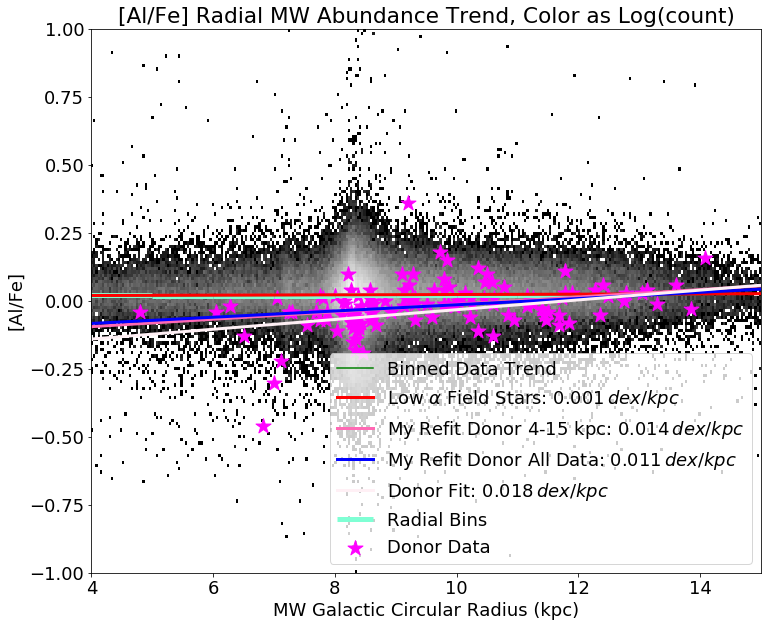

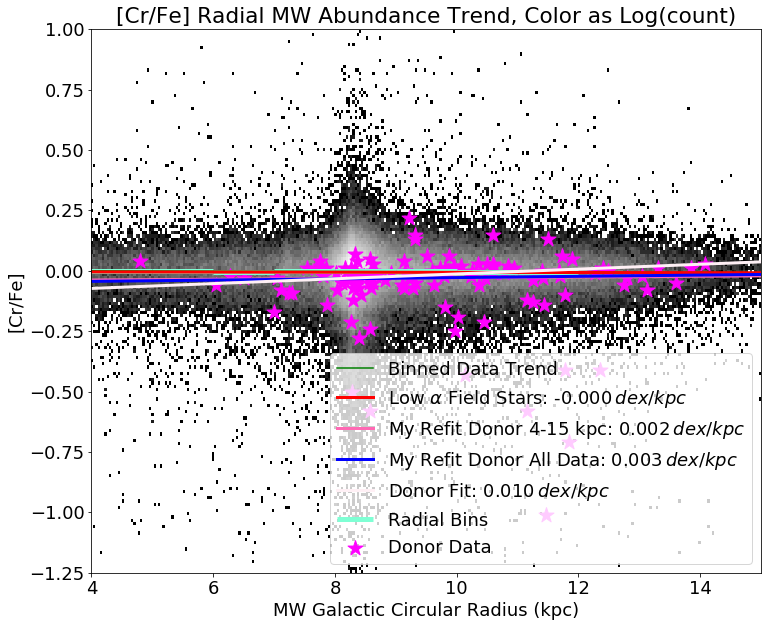

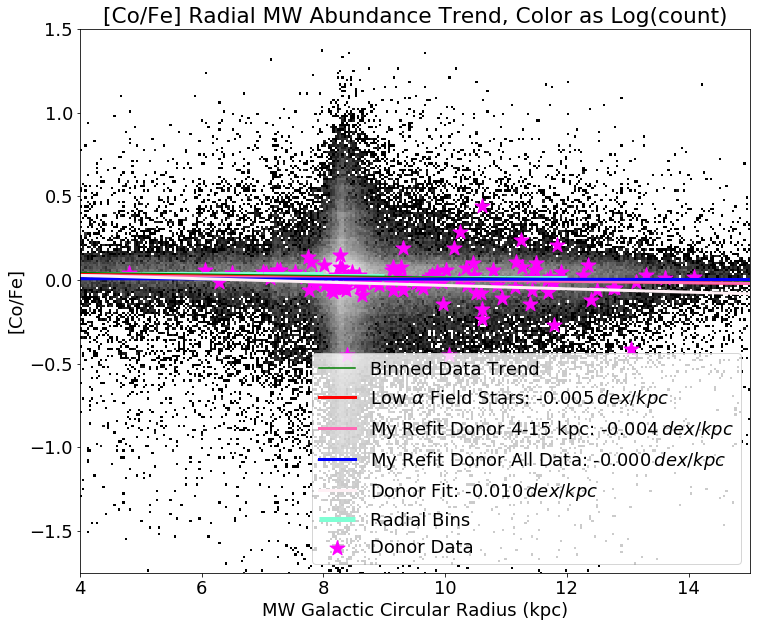

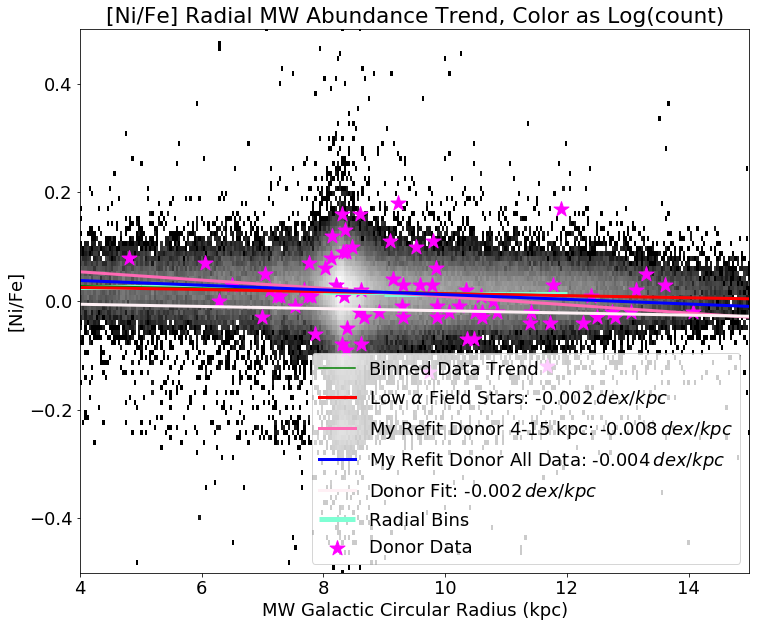

In [29]:
###########[Fe, O, Mg, Si, Ca, Na, Al, Cr, Co, Ni]
donfit_m = [0,0.013,0.009,-0.01,0.013,-0.025,0.018,0.010,-0.010,-0.002]
#[0,0.013,0.009,0.002,0.013,-0.012,0.018,0.010,-0.010,-0.002]
donfit_b = [0,-0.125,-0.110,0.009,-0.114,0.303,-0.212,-0.113,0.068,0.002]

lower_y = [0,-0.5,-0.5,-0.5,-0.75,-1.0,-1.0,-1.25,-1.75,-0.5]
upper_y = [0,0.5,0.5,0.5,0.75,1.0,1.0,1.0,1.5,0.5]

bin_m = [] 
bin_b = []


for i in tqdm_notebook(np.delete(range(len(idx)),0),desc='plots'):
    xval = np.linspace(4.0,15.0)
 
    def trendline(x):
        return mw_grads[i]*x+mw_intes[i]
    
    def lessgrad(x):
        return less_grads[i]*x+less_intes[i]
    
    def johngrad(x):
        return john_grads[i]*x+john_intes[i]
    
    def donortrend(x):
        return donfit_m[i]*x+donfit_b[i]
    
    plt.figure(figsize=[12,10])
    
    cln = np.where((alphstars[thin][elems[idx[i]]]>-100)&(alphstars[thin]['SNR']>=100))
    density = binned_statistic_2d(galmwrad[selstars][thin][cln],alphstars[thin][elems[idx[i]]][cln],None,'count',
                                  bins=300)
    plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
                                                                     density.y_edge[0],density.y_edge[-1]],
               aspect='auto', interpolation='nearest',cmap='binary_r',label='_nolegend_')

    bin_stats, bin_edges, binnumber = binned_statistic(galmwrad[selstars][thin][cln],
                                                       alphstars[thin][elems[idx[i]]][cln],statistic='median',
                                                       bins=[4,5,6,7,8,9,10,11,12])
    plt.hlines(bin_stats, bin_edges[:-1], bin_edges[1:], colors='aquamarine', lw=5.0,label='Radial Bins')
    
    x_mids = np.array([4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
    z,cov = np.polyfit(x_mids, bin_stats, 1,cov=True)
    bin_m.append(z[0])
    bin_b.append(z[1])
    p = np.poly1d(z)
    plt.plot(xval,p(xval),c='green',label='Binned Data Trend')
    
    plt.plot(xval,trendline(xval),c='r',lw=3.0,label=r'Low $\alpha$ Field Stars: {:>5.3f}$ \,dex/kpc$'.format(mw_grads[i]))
    plt.plot(xval,lessgrad(xval),c='hotpink',lw=3.0,label='My Refit Donor 4-15 kpc: {:>5.3f}$ \,dex/kpc$'.format(less_grads[i]))
    plt.plot(xval,johngrad(xval),c='blue',lw=3.0,label='My Refit Donor All Data: {:>5.3f}$ \,dex/kpc$'.format(john_grads[i]))
    
    plt.plot(xval,donortrend(xval),c='lavenderblush',lw=3.0,label='Donor Fit: {:>5.3f}$ \,dex/kpc$'.format(donfit_m[i]))
    
    clnjohn = np.where((donortable2[donorelems[i]]!=-9999.0)&(donortable2[donorelems[i]]<100.0))
    plt.scatter(donortable1['rgc'][clnjohn],donor_cls[i][clnjohn],c='magenta',marker='*',s=250,
                label='Donor Data')
    plt.legend(loc='lower right')
    plt.title(r'{} Radial MW Abundance Trend, Color as Log(count)'.format(labls[idx[i]]))
    plt.ylabel(r'{}'.format(labls[idx[i]]))
    plt.xlabel(r'MW Galactic Circular Radius (kpc)')
    plt.xlim(4,15)
    plt.ylim(lower_y[i],upper_y[i])
    plt.savefig('MWrad{}_w_trendslog.pdf'.format(els2[i]),bbox_inches='tight')
    plt.show()

## sodium only

In [30]:
binm_devs = []
binb_devs = []

for i in tqdm_notebook(range(len(idx)),desc='plots'):
    binslopes = []
    bininters = []
    cln = np.where((alphstars[thin][elems[i]]>-100)&(alphstars[thin]['SNR']>=100))
    clnstrs = alphstars[thin][elems[i]][cln]
    
    bin_stats, bin_edges, binnumber = binned_statistic(galmwrad[selstars][thin][cln],
                                                       clnstrs,statistic='median', bins=[4,5,6,7,8,9,10,11,12])
    
    for j in tqdm_notebook(range(100),desc='iterations'):
        x_mids = np.array([4.5+2*np.random.rand(),5.5+2*np.random.rand(),6.5+2*np.random.rand(),7.5+2*np.random.rand(),
                           8.5+2*np.random.rand(),9.5+2*np.random.rand(),10.5+2*np.random.rand(),11.5+2*np.random.rand()])
        z = np.polyfit(x_mids, bin_stats, 1)
        binslopes.append(z[0])
        bininters.append(z[1])
        
    binm_devs.append(mad(binslopes))
    binb_devs.append(mad(bininters))
    
# mwm_devs = []
# mwb_devs = []
# for j in tqdm_notebook(range(len(elems)-5),desc='elements'):
#     mwslopes = []
#     mwinters = []
    
#     cln = np.where((alphstars[thin][elems[j]]>-100)&(alphstars[thin]['SNR']>=100))
#     clnstrs = alphstars[thin][elems[j]][cln]
    
#     for k in tqdm_notebook(range(1000),desc='iterations'):
        
#         ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
#         indstrs = clnstrs[ind]
        
#         pmodl = np.array(galmwrad[selstars][thin][cln][ind]/scale).T
#         pmodl = sm.add_constant(pmodl)
#         model = sm.RLM(indstrs,pmodl).fit()
#         mwslopes.append(model.params[1])
#         mwinters.append(model.params[0])
        
#     mwm_devs.append(mad(mwslopes))
#     mwb_devs.append(mad(mwinters))

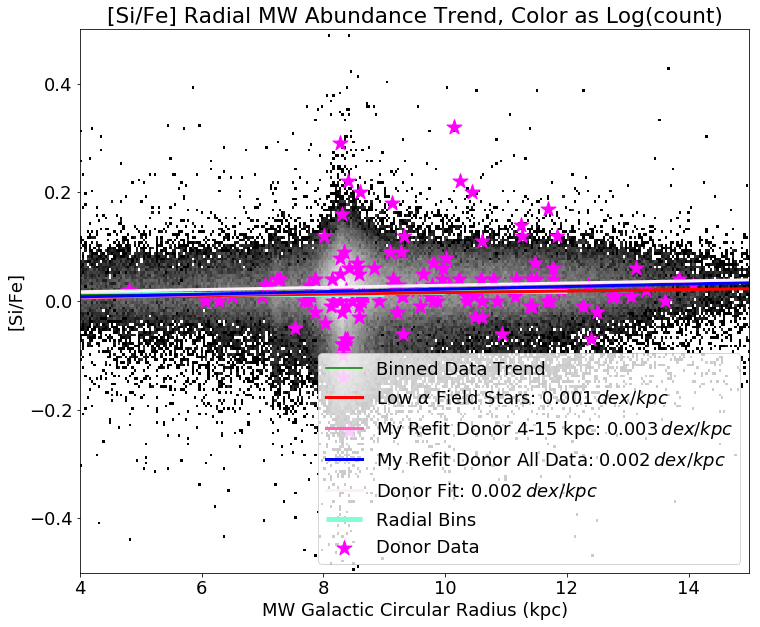

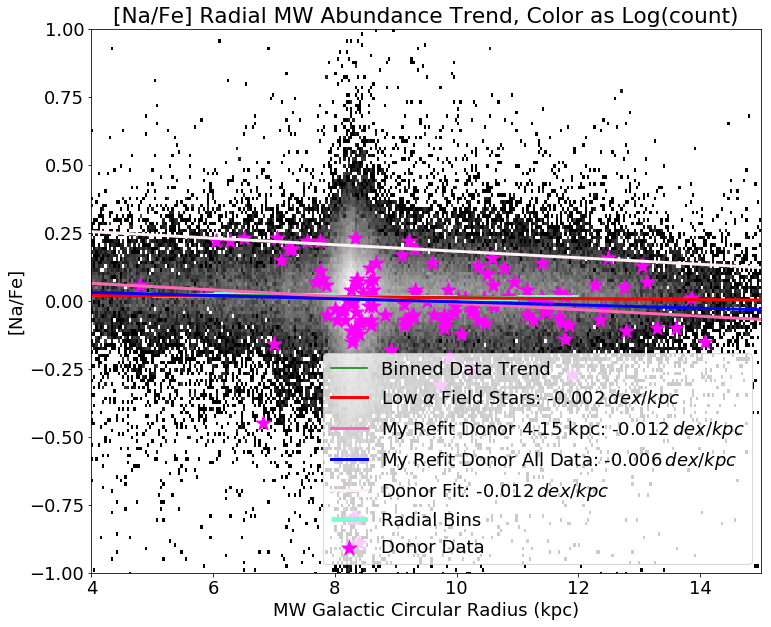

In [31]:
###########[Fe, O, Mg, Si, Ca, Na, Al, Cr, Co, Ni]
donfit_m = [0,0.013,0.009,0.002,0.013,-0.012,0.018,0.010,-0.010,-0.002]
#[0,0.013,0.009,0.002,0.013,-0.012,0.018,0.010,-0.010,-0.002]
donfit_b = [0,-0.125,-0.110,0.009,-0.114,0.303,-0.212,-0.113,0.068,0.002]

lower_y = [0,-0.5,-0.5,-0.5,-0.75,-1.0,-1.0,-1.25,-1.75,-0.5]
upper_y = [0,0.5,0.5,0.5,0.75,1.0,1.0,1.0,1.5,0.5]

bin_m1 = [] 
bin_b1 = []


for i in tqdm_notebook(np.delete(range(len(idx)),np.array([0,1,2,4,6,7,8,9])),desc='plots'):
    xval = np.linspace(4.0,15.0)
 
    def trendline(x):
        return mw_grads[i]*x+mw_intes[i]
    
    def lessgrad(x):
        return less_grads[i]*x+less_intes[i]
    
    def johngrad(x):
        return john_grads[i]*x+john_intes[i]
    
    def donortrend(x):
        return donfit_m[i]*x+donfit_b[i]
    
    plt.figure(figsize=[12,10])
    
    cln = np.where((alphstars[thin][elems[idx[i]]]>-100)&(alphstars[thin]['SNR']>=100))
    density = binned_statistic_2d(galmwrad[selstars][thin][cln],alphstars[thin][elems[idx[i]]][cln],None,'count',
                                  bins=300)
    plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
                                                                     density.y_edge[0],density.y_edge[-1]],
               aspect='auto', interpolation='nearest',cmap='binary_r',label='_nolegend_')

    bin_stats, bin_edges, binnumber = binned_statistic(galmwrad[selstars][thin][cln],
                                                       alphstars[thin][elems[idx[i]]][cln],statistic='median',
                                                       bins=[4,5,6,7,8,9,10,11,12])
    plt.hlines(bin_stats, bin_edges[:-1], bin_edges[1:], colors='aquamarine', lw=5.0,label='Radial Bins')
    
    x_mids = np.array([4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
    z,cov = np.polyfit(x_mids, bin_stats, 1,cov=True)
    bin_m1.append(z[0])
    bin_b1.append(z[1])
    p = np.poly1d(z)
    plt.plot(xval,p(xval),c='green',label='Binned Data Trend')
    
    plt.plot(xval,trendline(xval),c='r',lw=3.0,label=r'Low $\alpha$ Field Stars: {:>5.3f}$ \,dex/kpc$'.format(mw_grads[i]))
    plt.plot(xval,lessgrad(xval),c='hotpink',lw=3.0,label='My Refit Donor 4-15 kpc: {:>5.3f}$ \,dex/kpc$'.format(less_grads[i]))
    plt.plot(xval,johngrad(xval),c='blue',lw=3.0,label='My Refit Donor All Data: {:>5.3f}$ \,dex/kpc$'.format(john_grads[i]))
    
    plt.plot(xval,donortrend(xval),c='lavenderblush',lw=3.0,label='Donor Fit: {:>5.3f}$ \,dex/kpc$'.format(donfit_m[i]))
    
    clnjohn = np.where((donortable2[donorelems[i]]!=-9999.0)&(donortable2[donorelems[i]]<100.0))
    plt.scatter(donortable1['rgc'][clnjohn],donor_cls[i][clnjohn],c='magenta',marker='*',s=250,
                label='Donor Data')
    plt.legend(loc='lower right')
    plt.title(r'{} Radial MW Abundance Trend, Color as Log(count)'.format(labls[idx[i]]))
    plt.ylabel(r'{}'.format(labls[idx[i]]))
    plt.xlabel(r'MW Galactic Circular Radius (kpc)')
    plt.xlim(4,15)
    plt.ylim(lower_y[i],upper_y[i])
    plt.savefig('MWrad_{}paper.pdf'.format(els2[i]),bbox_inches='tight')
    plt.show()

In [45]:
donortable1

name,qual,l,b,radius,age,rgc,pmRA,e_pmRA,pmDE,e_pmDE,HRV,e_HRV,FEH,e_FEH,N
str13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
Czernik_21,1,171.8933,0.4622,6.6,2.24,12.27,2.38,0.09,-1.04,0.07,45.0,0.3,-0.32,0.01,2
Berkeley_71,2,176.6384,0.8936,4.8,1.05,11.26,0.69,0.08,-1.66,0.06,-9.4,0.3,-0.23,0.04,6
Chupina_1,0,215.3987,31.6938,5.0,0.01,8.57,-10.89,0.14,-2.77,0.1,33.8,0.2,-0.0,0.02,2
NGC_188,2,122.8416,22.384,17.7,4.47,9.14,-2.33,0.04,-0.92,0.03,-41.4,1.1,0.09,0.02,14
NGC_2202,0,203.5978,-4.8847,4.8,1.58,9.8,-0.97,0.03,0.53,0.03,52.8,0.1,-0.14,0.01,1
NGC_1245,2,146.6533,-8.9081,11.4,1.06,10.6,0.51,0.04,-1.63,0.03,-29.0,0.8,-0.08,0.02,24
NGC_2243,1,239.48,-18.0146,5.1,1.36,10.78,-1.28,0.02,5.5,0.02,59.8,0.4,-0.46,0.03,8
Czernik_7,0,131.1573,0.5299,3.9,1.31,10.23,-0.39,0.01,-0.45,0.02,-39.5,0.0,-0.07,0.01,1
FSR_0687,0,156.9333,0.967,5.0,0.0,11.5,0.53,0.08,0.35,0.05,-29.3,0.4,-0.15,0.02,1


In [ ]:
###########[Fe, O, Mg, Si, Ca, Na, Al, Cr, Co, Ni]
donfit_m = [0,0.013,0.009,-0.01,0.013,-0.025,0.018,0.010,-0.010,-0.002]
#[0,0.013,0.009,0.002,0.013,-0.012,0.018,0.010,-0.010,-0.002]
donfit_b = [0,-0.125,-0.110,0.009,-0.114,0.303,-0.212,-0.113,0.068,0.002]

lower_y = [0,-0.5,-0.5,-0.5,-0.75,-1.0,-1.0,-1.25,-1.75,-0.5]
upper_y = [0,0.5,0.5,0.5,0.75,1.0,1.0,1.0,1.5,0.5]

bin_m = [] 
bin_b = []


for i in tqdm_notebook(np.delete(range(len(idx)),0),desc='plots'):
    xval = np.linspace(4.0,15.0)
 
    def trendline(x):
        return mw_grads[i]*x+mw_intes[i]
    
    def lessgrad(x):
        return less_grads[i]*x+less_intes[i]
    
    def johngrad(x):
        return john_grads[i]*x+john_intes[i]
    
    def donortrend(x):
        return donfit_m[i]*x+donfit_b[i]
    
    plt.figure(figsize=[12,10])
    
    cln = np.where((alphstars[thin][elems[idx[i]]]>-100)&(alphstars[thin]['SNR']>=100))
    density = binned_statistic_2d(galmwrad[selstars][thin][cln],alphstars[thin][elems[idx[i]]][cln],None,'count',
                                  bins=300)
    plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
                                                                     density.y_edge[0],density.y_edge[-1]],
               aspect='auto', interpolation='nearest',cmap='binary_r',label='_nolegend_')

    bin_stats, bin_edges, binnumber = binned_statistic(galmwrad[selstars][thin][cln],
                                                       alphstars[thin][elems[idx[i]]][cln],statistic='median',
                                                       bins=[4,5,6,7,8,9,10,11,12])
    plt.hlines(bin_stats, bin_edges[:-1], bin_edges[1:], colors='aquamarine', lw=5.0,label='Radial Bins')
    
    x_mids = np.array([4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
    z,cov = np.polyfit(x_mids, bin_stats, 1,cov=True)
    bin_m.append(z[0])
    bin_b.append(z[1])
    p = np.poly1d(z)
    plt.plot(xval,p(xval),c='green',label='Binned Data Trend')
    
    plt.plot(xval,trendline(xval),c='r',lw=3.0,label=r'Low $\alpha$ Field Stars: {:>5.3f}$ \,dex/kpc$'.format(mw_grads[i]))
    plt.plot(xval,lessgrad(xval),c='hotpink',lw=3.0,label='My Refit Donor 4-15 kpc: {:>5.3f}$ \,dex/kpc$'.format(less_grads[i]))
    plt.plot(xval,johngrad(xval),c='blue',lw=3.0,label='My Refit Donor All Data: {:>5.3f}$ \,dex/kpc$'.format(john_grads[i]))
    
    plt.plot(xval,donortrend(xval),c='lavenderblush',lw=3.0,label='Donor Fit: {:>5.3f}$ \,dex/kpc$'.format(donfit_m[i]))
    
    clnjohn = np.where((donortable2[donorelems[i]]!=-9999.0)&(donortable2[donorelems[i]]<100.0))
    plt.scatter(donortable1['rgc'][clnjohn],donor_cls[i][clnjohn],c='magenta',marker='*',s=250,
                label='Donor Data')
    plt.legend(loc='lower right')
    plt.title(r'{} Radial MW Abundance Trend, Color as Log(count)'.format(labls[idx[i]]))
    plt.ylabel(r'{}'.format(labls[idx[i]]))
    plt.xlabel(r'MW Galactic Circular Radius (kpc)')
    plt.xlim(4,15)
    plt.ylim(lower_y[i],upper_y[i])
    plt.savefig('MWrad{}_w_trendslog.pdf'.format(els2[i]),bbox_inches='tight')
    plt.show()

In [32]:
# johnnoisy_values = []
johnm_devs = []
johnb_devs = []

donorelems = ['FEH','OFE','MGFE','SIFE','CAFE','NAFE','ALFE','CRFE','COFE','NIFE']
for j in tqdm_notebook(range(len(donorelems)),desc='Fit to Donor All Uncert'):
    johnslopes = []
    johninters = []
    
    cln = np.where((donortable2[donorelems[j]]!=-9999.0)&(donortable2[donorelems[j]]<100.0))
    clnstrs = donortable2[donorelems[j]][cln]
    
    for k in tqdm_notebook(range(1000),desc='iterations',leave=False):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        pmodl = np.array(donortable1['rgc'][cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(indstrs,pmodl).fit()
        johnslopes.append(model.params[1])
        johninters.append(model.params[0])
        
    johnm_devs.append(mad(johnslopes))
    johnb_devs.append(mad(johninters))
    
    
regionm_devs = []
regionb_devs = []

donorelems = ['FEH','OFE','MGFE','SIFE','CAFE','NAFE','ALFE','CRFE','COFE','NIFE']
for j in tqdm_notebook(range(len(donorelems)),desc='Fit to Donor 4-15kpc Uncert'):
    regionslopes = []
    regioninters = []
    
    cln = np.where((donortable1['rgc']<15.0)&(donortable1['rgc']>4.0)&
                   (donortable2[donorelems[j]]!=-9999.0)&(donortable2[donorelems[j]]<100.0))
    clnstrs = donortable2[donorelems[j]][cln]
    
    for k in tqdm_notebook(range(1000),desc='iterations',leave=False):
        
        ind = np.floor(np.random.random(len(clnstrs))*(len(clnstrs)-1)).astype(int)
        indstrs = clnstrs[ind]
        
        pmodl = np.array(donortable1['rgc'][cln]).T
        pmodl = sm.add_constant(pmodl)
        model = sm.RLM(indstrs,pmodl).fit()
        regionslopes.append(model.params[1])
        regioninters.append(model.params[0])
        
    regionm_devs.append(mad(regionslopes))
    regionb_devs.append(mad(regioninters))
    
    


In [33]:
bin_m

[0.0031313997072478137,
 0.0004638865856187675,
 0.0009610675763161409,
 0.0037009759495655716,
 -0.0020615408596183593,
 0.0005482607964603671,
 -0.0007475662444319047,
 -0.004674767676208705,
 -0.0022165985955368934]

In [34]:
idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
         np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
         np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
         np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
         np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

all_mw = []
low_mw = []
hig_mw = []
scerr_mw = []

bin_m2 = np.append(np.array([fegrad]),np.asarray(bin_m))
bin_devs = np.append(np.array([fegradsig]),np.asarray(sigma))

#Fe, O, Mg, Si, Ca, Na, Al, Cr, Co, Ni
donor_grads = [-0.065,0.013,0.009,0.002,0.012,-0.012,0.023,0.009,-0.004,0.000]
donor_devs = [0.001,0.001,0.001,0.001,0.001,0.004,0.002,0.004,0.004,0.001]

donfit_m2 = np.copy(donfit_m)
donfit_m2[0] = -0.068

for i in idx:

    all_mw.append(allmw_Fe_grads[i])
    low_mw.append(lowmw_Fe_grads[i])
    hig_mw.append(higmw_Fe_grads[i])
    scerr_mw.append(mwm_devs[i])
    

fig = plt.figure(figsize=[14,10])

# plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_over,marker='*',c='black',label='LMC Overall',s=200)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_over,yerr=scerr_over,c='black',capsize=5.0,ls='none')


plt.scatter([0,1,2,3,4,5,6,7,8,9],low_mw,marker='x',c='r',label='Low Alpha',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],low_mw,scerr_mw,c='r',capsize=5.0,ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],bin_m2,marker='x',c='aquamarine',label='Binned Data',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],bin_m2,binm_devs,c='aquamarine',capsize=5.0,ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],donfit_m2,marker='x',c='pink',label='Donor et al.',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],donfit_m2,donor_devs,c='pink',capsize=5.0,ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],john_grads,marker='x',c='hotpink',label='My Fit to all Johns Data',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],john_grads,johnm_devs,c='hotpink',capsize=5.0,ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],less_grads,marker='x',c='k',label='My Fit to all Johns 4-15kpc',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],less_grads,regionm_devs,c='k',capsize=5.0,ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$')

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.031,'Iron',fontsize=30)
plt.text(2.25,0.031,'$\\alpha$',fontsize=30)
plt.text(4.9,0.031,'Odd Z',fontsize=30)
plt.text(7.25,0.031,'Iron Peak',fontsize=30)

# plt.title(r'MW Gradients')

plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='x-large')
plt.savefig('mwsummary.pdf',bbox_inches='tight')
plt.show()

NameError: name 'sigma' is not defined

In [ ]:
donfit_m2

In [ ]:
# idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

# all_mw = []
# low_mw = []
# hig_mw = []
# scerr_mw = []

# bin_m22 = np.append(np.array([fegrad]),np.asarray(bin_m))
# bin_devs = np.append(np.array([fegradsig]),np.asarray(sigma))

# #Fe, O, Mg, Si, Ca, Na, Al, Cr, Co, Ni
# donor_grads = [-0.065,0.013,0.009,0.002,0.012,-0.012,0.023,0.009,-0.004,0.000]
# donor_devs = [0.001,0.001,0.001,0.001,0.001,0.004,0.002,0.004,0.004,0.001]

# donfit_m2 = np.copy(donfit_m)
# donfit_m2[0] = -0.068
# donfit_m2[3] = -0.001
# donfit_m2[5] = -0.025

# for i in idx:

#     all_mw.append(allmw_Fe_grads[i])
#     low_mw.append(lowmw_Fe_grads[i])
#     hig_mw.append(higmw_Fe_grads[i])
#     scerr_mw.append(mwm_devs[i])
    

# fig = plt.figure(figsize=[14,10])

# # plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_over,marker='*',c='black',label='LMC Overall',s=200)
# # plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_over,yerr=scerr_over,c='black',capsize=5.0,ls='none')


# plt.scatter([0,1,2,3,4,5,6,7,8,9],low_mw,marker='x',c='r',label='Low Alpha',s=100)

# plt.scatter([0,1,2,3,4,5,6,7,8,9],bin_m22,marker='x',c='aquamarine',label='Binned Data',s=100)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],bin_m22,binm_devs,c='aquamarine',capsize=5.0,ls='none')

# plt.scatter([0,1,2,3,4,5,6,7,8,9],donfit_m2,marker='x',c='pink',label='Donor et al.',s=100)

# plt.scatter([0,1,2,3,4,5,6,7,8,9],john_grads,marker='x',c='hotpink',label='My Fit to all Johns Data',s=100)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],john_grads,johnm_devs,c='hotpink',capsize=5.0,ls='none')

# plt.scatter([0,1,2,3,4,5,6,7,8,9],less_grads,marker='x',c='k',label='My Fit to all Johns 4-15kpc',s=100)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],less_grads,regionm_devs,c='k',capsize=5.0,ls='none')

# plt.errorbar([0,1,2,3,4,5,6,7,8,9],low_mw,scerr_mw,c='r',capsize=5.0,ls='none')
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],donfit_m2,donor_devs,c='pink',capsize=5.0,ls='none')

# xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
#             '[Ni/Fe]']
# xplotpos = [0,1,2,3,4,5,6,7,8,9,10] 
# plt.xticks(xplotpos,xplotlab)

# plt.axvline(0.5,c='k',ls='--')
# plt.axvline(4.5,c='k',ls='--')
# plt.axvline(6.5,c='k',ls='--')
# plt.axhline(0.0,c='slategrey',ls='-')
# plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$')

# # plt.gca().set_ylim(top=0.05)

# plt.text(-0.375,0.031,'Iron',fontsize=30)
# plt.text(2.25,0.031,'$\\alpha$',fontsize=30)
# plt.text(4.9,0.031,'Odd Z',fontsize=30)
# plt.text(7.25,0.031,'Iron Peak',fontsize=30)

# # plt.title(r'MW Gradients')

# plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='x-large')
# plt.savefig('mwsummarylog.pdf',bbox_inches='tight')
# plt.show()

In [ ]:
donortable1[np.where((donortable1['rgc']<15.0)&(donortable1['rgc']>4.0))]

In [ ]:
len(donortable1)

In [ ]:
donortable1['name'][np.where((donortable1['rgc']>15.0))]

In [ ]:
donortable1['name'][np.where((donortable1['rgc']<4.0))]

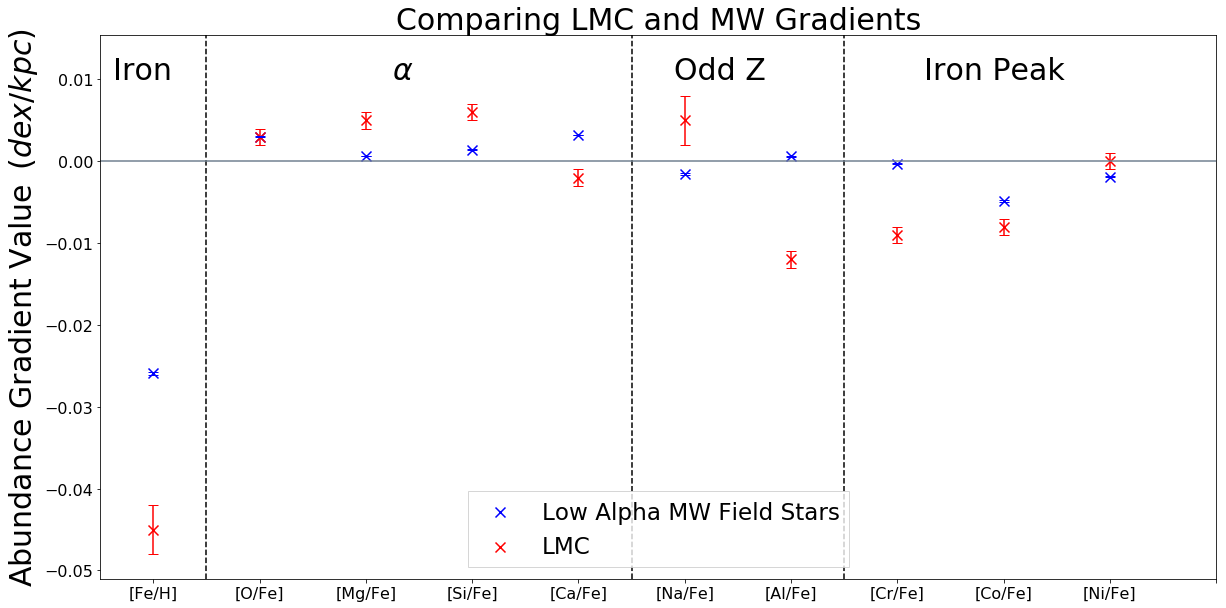

In [20]:
idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
         np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
         np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
         np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
         np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

all_mw = []
low_mw = []
hig_mw = []
scerr_mw = []

#Fe, O, Mg, Si, Ca, Na, Al, Cr, Co, Ni
donor_grads = [-0.065,0.013,0.009,0.002,0.012,-0.012,0.023,0.009,-0.004,0.000]
donor_devs = [0.001,0.001,0.001,0.001,0.001,0.004,0.002,0.004,0.004,0.001]

lmc_grads = [-0.045,0.003,0.005,0.006,-0.002,0.005,-0.012,-0.009,-0.008,0.000]
lmc_devs = [0.003,0.001,0.001,0.001,0.001,0.003,0.001,0.001,0.001,0.001] #both Ni and Ca have been inflated

for i in idx:

    all_mw.append(allmw_Fe_grads[i])
    low_mw.append(lowmw_Fe_grads[i])
    hig_mw.append(higmw_Fe_grads[i])
    scerr_mw.append(mwm_devs[i])
    
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=[20,10])

# plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_over,marker='*',c='black',label='LMC Overall',s=200)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_over,yerr=scerr_over,c='black',capsize=5.0,ls='none')

# plt.scatter([0,1,2,3,4,5,6,7,8,9],all_mw,marker='s',c='k',label='All Milky Way',s=100)
plt.scatter([0,1,2,3,4,5,6,7,8,9],low_mw,marker='x',c='b',label='Low Alpha MW Field Stars',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],low_mw,scerr_mw,c='b',capsize=5.0,ls='none')

# plt.scatter([0,1,2,3,4,5,6,7,8,9],hig_mw,marker='s',c='r',label='High Alpha',s=100)

# plt.scatter([0,1,2,3,4,5,6,7,8,9],donor_grads,marker='x',c='g',label='MW Open Clusters (Donor et al. 2020)',s=100)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],donor_grads,donor_devs,c='g',capsize=5.0,ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],lmc_grads,marker='x',c='r',label='LMC',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],lmc_grads,lmc_devs,c='r',capsize=5.0,ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.01,'Iron',fontsize=30)
plt.text(2.25,0.01,'$\\alpha$',fontsize=30)
plt.text(4.9,0.01,'Odd Z',fontsize=30)
plt.text(7.25,0.01,'Iron Peak',fontsize=30)

plt.title(r'Comparing LMC and MW Gradients',fontsize=30)

plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='x-large')
plt.savefig('mwfieldwLMC.pdf',bbox_inches='tight')
plt.show()